# FinOptix

#FAC Summer Project 2025

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# MVO Optimization Function

In [2]:
class MVOOptimizer:
    """Class to implement Mean-Variance Optimization (MVO)"""

    def __init__(self, returns_data, risk_free_rate=0.02):
        self.returns = returns_data
        self.risk_free_rate = risk_free_rate
        self.mean_returns = None
        self.cov_matrix = None
        self.efficient_frontier = None
        self.optimal_weights = None

    def calculate_portfolio_metrics(self, weights):
        """Calculate portfolio return and risk"""
        portfolio_return = np.sum(self.mean_returns * weights) * 252
        portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix * 252, weights)))
        return portfolio_return, portfolio_risk

    def negative_sharpe_ratio(self, weights):
        """Calculate negative Sharpe ratio for optimization"""
        p_return, p_risk = self.calculate_portfolio_metrics(weights)
        return -(p_return - self.risk_free_rate) / p_risk

    def calculate_efficient_frontier(self, num_portfolios=100):
        """Calculate efficient frontier"""
        self.mean_returns = self.returns.mean()
        self.cov_matrix = self.returns.cov()

        num_assets = len(self.mean_returns)

        # Generate target returns
        min_ret = self.mean_returns.min() * 252
        max_ret = self.mean_returns.max() * 252
        target_returns = np.linspace(min_ret, max_ret, num_portfolios)

        efficient_portfolios = []

        for target in target_returns:
            # Constraints
            constraints = [
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Weights sum to 1
                {'type': 'eq', 'fun': lambda x: np.sum(self.mean_returns * x) * 252 - target}  # Target return
            ]

            # Bounds (no short selling)
            bounds = tuple((0, 1) for _ in range(num_assets))

            # Initial guess
            x0 = np.array([1/num_assets] * num_assets)

            # Minimize portfolio variance
            def portfolio_variance(weights):
                return np.dot(weights.T, np.dot(self.cov_matrix * 252, weights))

            result = minimize(portfolio_variance, x0, method='SLSQP',
                            bounds=bounds, constraints=constraints)

            if result.success:
                weights = result.x
                p_return, p_risk = self.calculate_portfolio_metrics(weights)
                efficient_portfolios.append([p_risk, p_return, weights])

        self.efficient_frontier = pd.DataFrame(efficient_portfolios,
                                            columns=['Risk', 'Return', 'Weights'])

    def find_optimal_portfolio(self):
        """Find portfolio with maximum Sharpe ratio"""
        if self.mean_returns is None:
            self.mean_returns = self.returns.mean()
            self.cov_matrix = self.returns.cov()

        num_assets = len(self.mean_returns)

        # Constraints and bounds
        constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
        bounds = tuple((0, 1) for _ in range(num_assets))
        x0 = np.array([1/num_assets] * num_assets)

        # Optimize for maximum Sharpe ratio
        result = minimize(self.negative_sharpe_ratio, x0, method='SLSQP',
                         bounds=bounds, constraints=constraints)

        if result.success:
            self.optimal_weights = result.x
            optimal_return, optimal_risk = self.calculate_portfolio_metrics(self.optimal_weights)
            optimal_sharpe = (optimal_return - self.risk_free_rate) / optimal_risk

            return {
                'weights': self.optimal_weights,
                'return': optimal_return,
                'risk': optimal_risk,
                'sharpe_ratio': optimal_sharpe
            }
        else:
            return None

    def plot_efficient_frontier(self):
        """Plot efficient frontier and optimal portfolio"""
        if self.efficient_frontier is None:
            self.calculate_efficient_frontier()

        optimal_portfolio = self.find_optimal_portfolio()

        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle('Mean-Variance Optimization (MVO) Analysis', fontsize=16, fontweight='bold')

        # Plot 1: Efficient Frontier
        axes[0].plot(self.efficient_frontier['Risk'], self.efficient_frontier['Return'],
                    'b-', linewidth=2, label='Efficient Frontier')

        # Plot individual assets
        for asset in self.returns.columns:
            asset_return = self.mean_returns[asset] * 252
            asset_risk = self.returns[asset].std() * np.sqrt(252)
            axes[0].scatter(asset_risk, asset_return, s=100, label=asset)

        # Plot optimal portfolio
        if optimal_portfolio:
            axes[0].scatter(optimal_portfolio['risk'], optimal_portfolio['return'],
                          s=200, color='red', marker='*', label='Optimal Portfolio')

        axes[0].set_xlabel('Risk (Standard Deviation)')
        axes[0].set_ylabel('Expected Return')
        axes[0].set_title('Efficient Frontier')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Plot 2: Optimal Portfolio Weights
        if optimal_portfolio:
            weights_df = pd.DataFrame({
                'Asset': self.returns.columns,
                'Weight': optimal_portfolio['weights']
            })

            axes[1].pie(weights_df['Weight'], labels=weights_df['Asset'], autopct='%1.1f%%')
            axes[1].set_title('Optimal Portfolio Weights')

        plt.tight_layout()
        plt.show()

        return optimal_portfolio

# Main Function

In [3]:
def main_example():
    """Main function demonstrating CAPM and MVO with real data"""

    print("=" * 60)
    print("MEAN-VARIANCE OPTIMIZATION ANALYSIS")
    print("=" * 60)

    # Download sample data (last 2 years)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=730)

    # Stock symbols for analysis
    stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
    market_symbol = '^GSPC'  # S&P 500 as market proxy

    print(f"Downloading data for: {', '.join(stocks)}")
    print(f"Market proxy: S&P 500 ({market_symbol})")
    print(f"Period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
    print()

    # Download data
    try:
        stock_data = yf.download(stocks, start=start_date, end=end_date)['Adj Close']
        market_data = yf.download(market_symbol, start=start_date, end=end_date)['Adj Close']
    except Exception as e:
        print(f"Error downloading data: {e}")
        # Use synthetic data as fallback
        print("Using synthetic data for demonstration...")
        np.random.seed(42)
        dates = pd.date_range(start=start_date, end=end_date, freq='D')
        stock_data = pd.DataFrame(np.random.randn(len(dates), len(stocks)).cumsum(axis=0) + 100,
                                 index=dates, columns=stocks)
        market_data = pd.Series(np.random.randn(len(dates)).cumsum() + 100, index=dates)


    # MVO Analysis
    print("\n" + "="*40)
    print("MEAN-VARIANCE OPTIMIZATION")
    print("="*40)

    returns_data = stock_data.pct_change().dropna()
    mvo = MVOOptimizer(returns_data, risk_free_rate=0.02)

    # Find optimal portfolio
    optimal_portfolio = mvo.find_optimal_portfolio()

    if optimal_portfolio:
        print("\nOptimal Portfolio (Maximum Sharpe Ratio):")
        print(f"Expected Return: {optimal_portfolio['return']:.4f} ({optimal_portfolio['return']*100:.2f}%)")
        print(f"Risk (Std Dev): {optimal_portfolio['risk']:.4f} ({optimal_portfolio['risk']*100:.2f}%)")
        print(f"Sharpe Ratio: {optimal_portfolio['sharpe_ratio']:.4f}")

        print("\nOptimal Weights:")
        for i, stock in enumerate(stocks):
            weight = optimal_portfolio['weights'][i]
            print(f"- {stock}: {weight:.4f} ({weight*100:.2f}%)")

    # Plot efficient frontier
    mvo.plot_efficient_frontier()

    # Additional Analysis: Risk-Return Comparison
    print("\n" + "="*40)
    print("INDIVIDUAL ASSET ANALYSIS")
    print("="*40)

    individual_metrics = []
    for stock in stocks:
        stock_return = returns_data[stock].mean() * 252
        stock_risk = returns_data[stock].std() * np.sqrt(252)
        stock_sharpe = (stock_return - 0.02) / stock_risk
        individual_metrics.append([stock, stock_return, stock_risk, stock_sharpe])

    metrics_df = pd.DataFrame(individual_metrics,
                             columns=['Asset', 'Return', 'Risk', 'Sharpe_Ratio'])
    print(metrics_df.round(4))

    print("\n" + "="*60)
    print("ANALYSIS COMPLETE")
    print("="*60)

MEAN-VARIANCE OPTIMIZATION ANALYSIS
Market proxy: S&P 500 (^GSPC)
Period: 2023-07-07 to 2025-07-06



[*********************100%***********************]  5 of 5 completed


Error downloading data: 'Adj Close'
Using synthetic data for demonstration...

MEAN-VARIANCE OPTIMIZATION

Optimal Portfolio (Maximum Sharpe Ratio):
Expected Return: 0.1331 (13.31%)
Risk (Std Dev): 0.0855 (8.55%)
Sharpe Ratio: 1.3223

Optimal Weights:
- AAPL: 0.1640 (16.40%)
- GOOGL: 0.0000 (0.00%)
- MSFT: 0.0000 (0.00%)
- AMZN: 0.2392 (23.92%)
- TSLA: 0.5968 (59.68%)


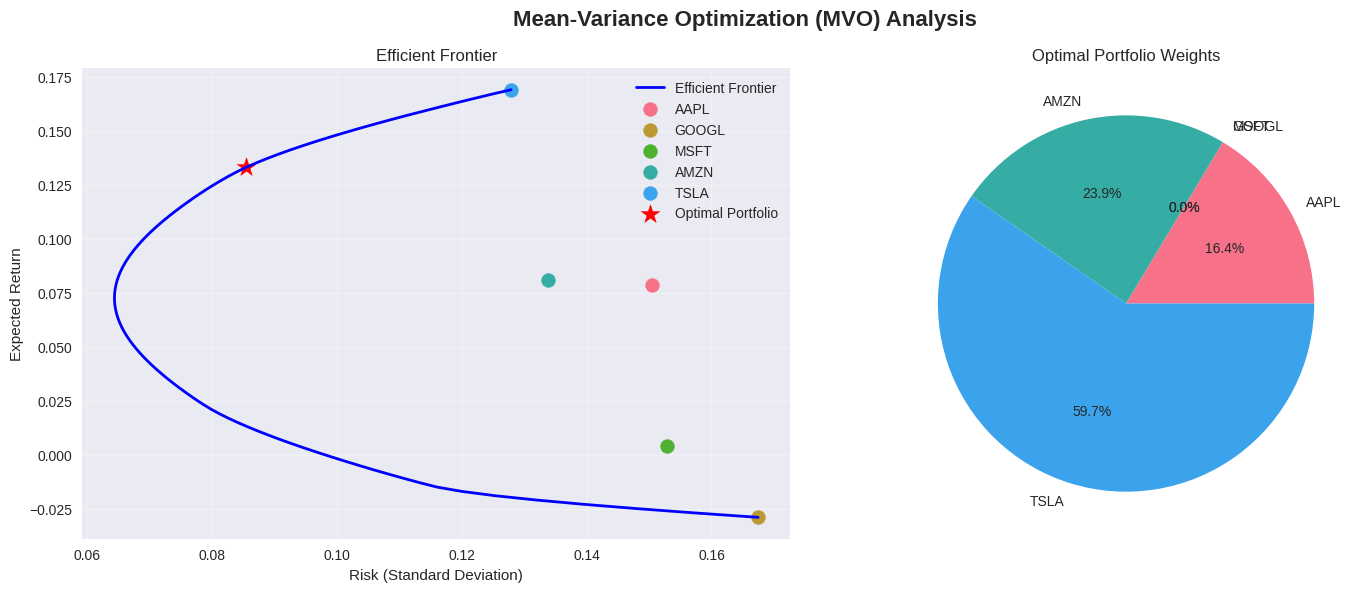


INDIVIDUAL ASSET ANALYSIS
   Asset  Return    Risk  Sharpe_Ratio
0   AAPL  0.0784  0.1504        0.3882
1  GOOGL -0.0290  0.1675       -0.2929
2   MSFT  0.0038  0.1528       -0.1062
3   AMZN  0.0810  0.1338        0.4559
4   TSLA  0.1689  0.1279        1.1645

ANALYSIS COMPLETE


In [4]:
if __name__ == "__main__":
    main_example()